# Iterative Training on Coughvid + Coswara data (Part 2: Fusion)

## 1. Preparing the environment

First, the colab is mounted onto the drive to access data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Libraries are imported for processing and training purpose

In [ ]:
# File handling
import os
import pandas as pd

In [ ]:
# Audio data handling
import librosa
import librosa.util
import numpy as np

In [ ]:
# Machinelearning
# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# tensor flow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Reshape, Bidirectional, Input, Concatenate, Multiply
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import applications

from tensorflow_hub import KerasLayer

# Regularization
from tensorflow.keras.regularizers import l2

# Metrics
from tensorflow.keras.metrics import Precision, Recall, AUC

In [ ]:
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# !nvidia-smi

In [ ]:
# # run this to clear GPU memory if needed
# import torch
# torch.cuda.empty_cache()

# import tensorflow as tf
# tf.keras.backend.clear_session()

## 2. Data preparation

You should only use the training and testing folder

In [ ]:
# check and verify the folders to access the data prepared earlier
metadata_path = "/content/drive/My Drive/AML/Data/dataset5_combined_coughvid_coswara/" # update this to local version
print(os.listdir(metadata_path))

['labels', 'combined_train_16mar', 'combined_test_16mar']


Specify the training and testing file folder (loading file names)

In [ ]:
# for standarising in all sub-datasets, a function is used
def list_files(directory, label):
    files_list = os.listdir(directory)
    total_files = len(files_list)
    sample_files = files_list[:10]
    print(f"Total {label} Files: {total_files}")
    print(f"Sample {label} Files:", sample_files)
    return total_files

In [ ]:
# Show distribution of labels
def plot_distribution(counts, labels, title):
    total = sum(counts)
    percentages = [(count / total) * 100 for count in counts]

    plt.figure(figsize=(6,4))
    bars = plt.bar(labels, counts, color=['lightblue', 'orange'])
    plt.xlabel("Dataset Type")
    plt.ylabel("Number of Files")
    plt.title(title)

    for bar, percentage in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width()/2, 10, f'{percentage:.1f}%',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.show()

In [ ]:
train_dir = os.path.join(metadata_path, 'combined_train_16mar') # use training folder specified above
test_dir = os.path.join(metadata_path, 'combined_test_16mar') # use test folder specified above

# Process train and test directories
total_train_files = list_files(train_dir, "Train")
total_test_files = list_files(test_dir, "Test")

Total Train Files: 2271
Sample Train Files: ['53d69964-ae7d-4ccc-a297-91a9b21c772e.wav', '8b66adaa-ff22-45f1-b74e-9719c0d544f9.wav', '35ec6e33-eeeb-4734-9a52-c37a949e5443.wav', '90df4728-8750-4646-a0a4-027f2c9cd544.wav', '076f59de-0637-4ee1-951c-f2e0784e8a53.wav', '9a70cfcf-2df1-4bbc-aed8-aa9afa094a9f.wav', '1cc88f3a-3529-4cb8-a167-fc0cb5b0bfb6.wav', '3a325d6e-929d-48f4-b640-36e08fa37cf4.wav', '34b77763-a4a4-4beb-aeaa-02ef8298ef31.wav', '3b6a0157-04a2-46cd-b5a7-299595293a2d.wav']
Total Test Files: 468
Sample Test Files: ['4fa54167-06c6-485a-a7b5-4b3696aa1393.wav', 'ab2598a4-3781-40ae-b4f2-6d34abd2039d.wav', '39e4cc19-0db4-492a-b580-9fc4e4ab62ea.wav', '9f40d734-f22c-400f-abed-87c15bedc69c.wav', 'a08ada1f-32e6-40cf-9513-57cf411cf97d.wav', '69e7b5c5-0469-42dd-b68f-9a7f7637425b.wav', 'be920126-b1e2-4117-84e2-461b2230e46e.wav', 'd11e501c-6f48-4028-8198-9075c67ce238.wav', '37347587-048a-4a1c-a100-7cf820711428.wav', 'ae321315-0798-4b11-a088-a2acdd099ffc.wav']


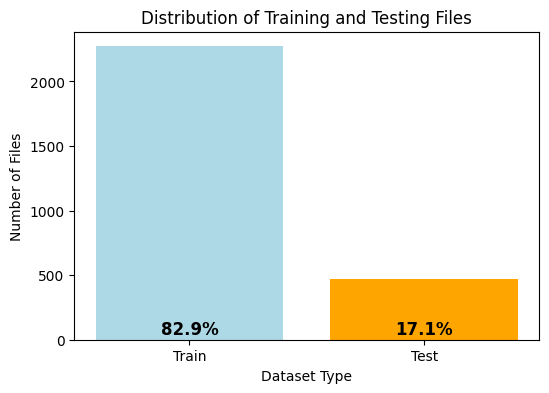

In [ ]:
# Plot distribution
plot_distribution([total_train_files, total_test_files], ["Train", "Test"], "Distribution of Training and Testing Files")

Loading the labels based on filenames above

In [ ]:
def load_labels_combined_train(file_path, dataset_name):
    data = pd.read_csv(file_path)
    data['health_status'] = data['health_status'].astype(int)
    print(f"Unique health_status labels in {dataset_name} set:", data['health_status'].unique())
    label_dict = {
      f"{id_}.wav" if not id_.endswith(".wav") else id_: label
      for id_, label in zip(data['filename'], data['health_status'])
  }
    print(f"Sample {dataset_name} labels:", list(label_dict.items())[:5])
    print(f"{len(label_dict)} {dataset_name} files labeled correctly.")
    return label_dict, data['health_status'].value_counts().to_dict()

In [ ]:
def load_labels_combined_test(file_path, dataset_name):
    data = pd.read_csv(file_path)
    print(f"Unique health_status labels in {dataset_name} set:", data['health_status'].unique())
    label_dict = {f"{id_}.wav": label for id_, label in zip(data['uuid'], data['health_status'])}
    print(f"Sample {dataset_name} labels:", list(label_dict.items())[:5])
    print(f"{len(label_dict)} {dataset_name} files labeled correctly.")
    return label_dict, data['health_status'].value_counts().to_dict()

In [ ]:
# move on to the labels folder
labels_path = os.path.join(metadata_path, "labels")

train_labels_path = os.path.join(labels_path, 'combined_train_16mar.csv') # use training label specified above
test_labels_path = os.path.join(labels_path, 'combined_test_16mar.csv') # use test label specified above

In [ ]:
# Load and process train and test label datasets
train_label_dict, train_label_counts = load_labels_combined_train(train_labels_path, "training")
test_label_dict, test_label_counts = load_labels_combined_test(test_labels_path, "testing")

Unique health_status labels in training set: [0 1]
Sample training labels: [('aa78817e-f5e3-470b-b516-6006c59fb1fa.wav', 0), ('7b7f6998-7f52-475f-8bbd-e76d80eafd91.wav', 0), ('506b5606-cecb-4fba-8723-c4a2bfb8b038.wav', 1), ('0f79324e-9dc6-4f6c-8c13-2a3041f044d1.wav', 0), ('e1d7fad3-6eb9-44db-ad0a-1f25cd555b53.wav', 1)]
2271 training files labeled correctly.
Unique health_status labels in testing set: [1 0]
Sample testing labels: [('7869b66e-5c53-42b8-8741-8e7398f78137.wav', 1), ('e80023d9-392a-407a-9580-9c66eb45d7bd.wav', 0), ('37347587-048a-4a1c-a100-7cf820711428.wav', 0), ('f0bc6079-5c16-4c95-91be-ddffc7bb37b0.wav', 0), ('ab2598a4-3781-40ae-b4f2-6d34abd2039d.wav', 0)]
468 testing files labeled correctly.


In [ ]:
import re  # Import regular expressions

# Define the regex pattern to check for ".wav.wav" occurrence
pattern = re.compile(r"\wav\.wav")

# Iterate through the labels and check for the pattern
for labels in train_label_dict.keys():
    if pattern.search(labels):  # If ".wav.wav" is found in the filename
        print(f"Invalid filename: {labels}")

In [ ]:
# Check if label count matches file count
if len(train_label_dict) == total_train_files:
    print("Training labels match the number of training files.")
else:
    print(f"Mismatch: {len(train_label_dict)} training labels vs. {total_train_files} training files.")

if len(test_label_dict) == total_test_files:
    print("Testing labels match the number of testing files.")
else:
    print(f"Mismatch: {len(test_label_dict)} testing labels vs. {total_test_files} testing files.")

Training labels match the number of training files.
Testing labels match the number of testing files.


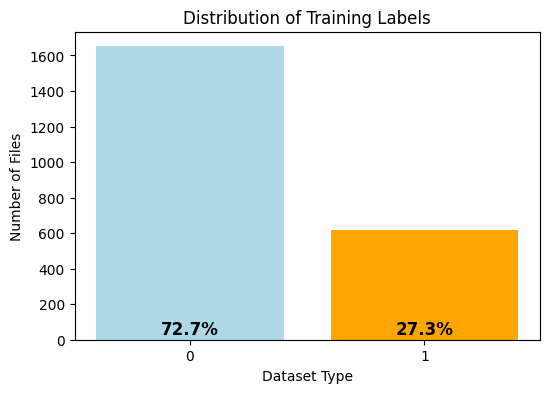

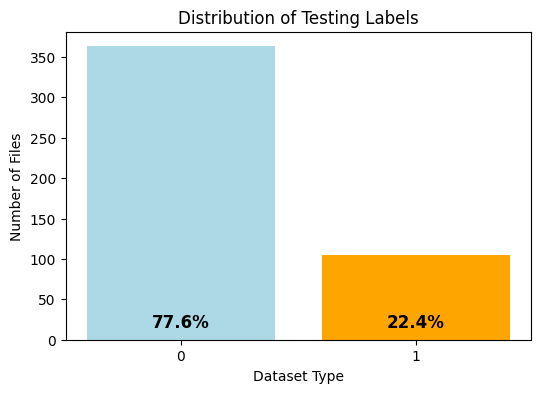

In [ ]:
# Plot distribution of labels in training set
plot_distribution(list(train_label_counts.values()), list(map(str, train_label_counts.keys())), "Distribution of Training Labels")

# Plot distribution of labels in testing set
plot_distribution(list(test_label_counts.values()), list(map(str, test_label_counts.keys())), "Distribution of Testing Labels")

The distribution is the same as expected - very imbalanced

Data are loaded in based on its location, the shapes are checked once again

In [ ]:
def load_audio_dataset(audio_dir, label_dict):
    """Load only the audio files mentioned in the label dictionary."""
    data = []
    labels = []
    filenames = []
    skipped_files = 0  # Counter for skipped files

    for filename in label_dict.keys():  # Iterate only over filenames in label_dict
        file_path = os.path.join(audio_dir, filename)

        # if not os.path.isfile(file_path) or os.path.getsize(file_path) < 10:
        if not os.path.isfile(file_path):
            print(f"Skipping {file_path} (file missing or too small)")
            skipped_files += 1
            continue  # Skip missing or small files

        try:
            # Load the audio file
            audio, sr = librosa.load(file_path, sr=None)
            data.append(audio)
            labels.append(label_dict[filename])
            filenames.append(filename)
        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            skipped_files += 1
            continue  # Skip problematic files

    print(f"Skipped {skipped_files} files due to errors.")
    return np.array(data, dtype=object), np.array(labels), filenames

In [ ]:
# Load train and test datasets from the same directory
X_train, y_train, train_files = load_audio_dataset(train_dir, train_label_dict)
X_test, y_test, test_files = load_audio_dataset(test_dir, test_label_dict)

# Print dataset summary
print(f"Training Data: {X_train.shape[0]} samples")
print(f"Test Data: {X_test.shape[0]} samples")

# Show sample audio shape
print("\nSample training shapes:")
for i, (audio, name) in enumerate(zip(X_train[:5], train_files[:5])):
    print(f"{name}: {audio.shape}")

print("\nSample test shapes:")
for i, (audio, name) in enumerate(zip(X_test[:5], test_files[:5])):
    print(f"{name}: {audio.shape}")

Skipped 0 files due to errors.
Skipped 0 files due to errors.
Training Data: 2271 samples
Test Data: 468 samples

Sample training shapes:
aa78817e-f5e3-470b-b516-6006c59fb1fa.wav: (71680,)
7b7f6998-7f52-475f-8bbd-e76d80eafd91.wav: (105472,)
506b5606-cecb-4fba-8723-c4a2bfb8b038.wav: (103744,)
0f79324e-9dc6-4f6c-8c13-2a3041f044d1.wav: (12800,)
e1d7fad3-6eb9-44db-ad0a-1f25cd555b53.wav: (33792,)

Sample test shapes:
7869b66e-5c53-42b8-8741-8e7398f78137.wav: (16896,)
e80023d9-392a-407a-9580-9c66eb45d7bd.wav: (38912,)
37347587-048a-4a1c-a100-7cf820711428.wav: (24064,)
f0bc6079-5c16-4c95-91be-ddffc7bb37b0.wav: (85504,)
ab2598a4-3781-40ae-b4f2-6d34abd2039d.wav: (64512,)


In [ ]:
def extract_mfcc(audio, sr, n_mfcc=13):
    """Extract MFCC features from raw audio."""
    return librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc).T  # (frames, features)

# Define a padding/truncation function
def pad_or_truncate(mfcc, target_frames):
    """Pads or truncates MFCC to the target number of frames."""
    num_frames = mfcc.shape[0]

    if num_frames < target_frames:
        # Pad with zeros at the end
        pad_width = target_frames - num_frames
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    elif num_frames > target_frames:
        # Truncate
        mfcc = mfcc[:target_frames, :]

    return mfcc

In [ ]:
# Extract MFCC features at 12kHz
X_train_mfcc = [extract_mfcc(audio, sr=12000) for audio in X_train]
X_test_mfcc = [extract_mfcc(audio, sr=12000) for audio in X_test]

In [ ]:
# Calculate MFCC lengths for all samples
mfcc_lengths = [mfcc.shape[0] for mfcc in X_train_mfcc]

# Compute statistics
min_frames = np.min(mfcc_lengths)
max_frames = np.max(mfcc_lengths)
mean_frames = np.mean(mfcc_lengths)
median_frames = np.median(mfcc_lengths)
percentile_90 = np.percentile(mfcc_lengths, 90)  # 90th percentile
percentile_95 = np.percentile(mfcc_lengths, 95)  # 95th percentile


# Print results
print(f"Min frames: {min_frames}")
print(f"Max frames: {max_frames}")
print(f"Mean frames: {mean_frames}")
print(f"Median frames: {median_frames}")
print(f"90th Percentile frames: {percentile_90}")
print(f"95th Percentile frames: {percentile_95}")

Min frames: 7
Max frames: 528
Mean frames: 91.95948921180097
Median frames: 87.0
90th Percentile frames: 163.0
95th Percentile frames: 184.0


In [ ]:
# Define target frame size
target_frames = 184

# Apply padding/truncation
X_train_mfcc_padded = np.array([pad_or_truncate(mfcc, target_frames) for mfcc in X_train_mfcc])
X_test_mfcc_padded = np.array([pad_or_truncate(mfcc, target_frames) for mfcc in X_test_mfcc])

# Print final shapes
print(f"Processed Training Data Shape: {X_train_mfcc_padded.shape}")
print(f"Processed Test Data Shape: {X_test_mfcc_padded.shape}")

Processed Training Data Shape: (2271, 184, 13)
Processed Test Data Shape: (468, 184, 13)


In [ ]:
# Compute statistics for X_train_mfcc_padded
train_mfcc_lengths = [mfcc.shape[0] for mfcc in X_train_mfcc_padded]

print("Train MFCC Statistics After Padding:")
print(f"Min frames: {np.min(train_mfcc_lengths)}")
print(f"Max frames: {np.max(train_mfcc_lengths)}")
print(f"Mean frames: {np.mean(train_mfcc_lengths)}")
print(f"Median frames: {np.median(train_mfcc_lengths)}")
print(f"90th percentile frames: {np.percentile(train_mfcc_lengths, 90)}")

# Compute statistics for X_test_mfcc_padded
test_mfcc_lengths = [mfcc.shape[0] for mfcc in X_test_mfcc_padded]

print("\nTest MFCC Statistics After Padding:")
print(f"Min frames: {np.min(test_mfcc_lengths)}")
print(f"Max frames: {np.max(test_mfcc_lengths)}")
print(f"Mean frames: {np.mean(test_mfcc_lengths)}")
print(f"Median frames: {np.median(test_mfcc_lengths)}")
print(f"90th percentile frames: {np.percentile(test_mfcc_lengths, 90)}")


Train MFCC Statistics After Padding:
Min frames: 184
Max frames: 184
Mean frames: 184.0
Median frames: 184.0
90th percentile frames: 184.0

Test MFCC Statistics After Padding:
Min frames: 184
Max frames: 184
Mean frames: 184.0
Median frames: 184.0
90th percentile frames: 184.0


In [ ]:
# Convert MFCC lists to NumPy arrays
X_train_mfcc_padded_fed = np.array(X_train_mfcc_padded)
X_test_mfcc_padded_fed = np.array(X_test_mfcc_padded)

# Add channel dimension if using CNNs
X_train_mfcc_padded_fed = X_train_mfcc_padded_fed[..., np.newaxis]
X_test_mfcc_padded_fed = X_test_mfcc_padded_fed[..., np.newaxis]

# Split training data into train and validation sets
X_train_fed, X_val_fed, y_train_fed, y_val_fed = train_test_split(
    X_train_mfcc_padded_fed, y_train, test_size=0.2, stratify=y_train, random_state=37
)

In [ ]:
# Print final shapes
print(f"X_train shape: {X_train_fed.shape}, y_train shape: {y_train_fed.shape}")
print(f"X_val shape: {X_val_fed.shape}, y_val shape: {y_val_fed.shape}")
print(f"X_test shape: {X_test_mfcc_padded_fed.shape}, y_test shape: {y_test.shape}")

X_train shape: (1816, 184, 13, 1), y_train shape: (1816,)
X_val shape: (455, 184, 13, 1), y_val shape: (455,)
X_test shape: (468, 184, 13, 1), y_test shape: (468,)


## 3. Machine Learning 1 (CNN and LSTM on MFCC)

Some functions are defined to understand the training history. They can be used for all models in this notebook

In [ ]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluates a given model on test data, generates predictions,
    plots a confusion matrix, and prints a classification report.

    Parameters:
    - model: Trained model to evaluate
    - X_test: Test input data
    - y_test: True labels for the test data
    - threshold: Probability threshold for binary classification (default: 0.5)
    """
    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > threshold).astype(int)  # Convert probabilities to binary labels

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
def evaluate_test_set(model, X_test, y_test):
    """
    Evaluates the given model on the test set and prints the results.

    Parameters:
    - model: Trained model to evaluate
    - X_test: Test input data
    - y_test: True labels for the test data
    """
    # Evaluate the model on the test set
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

Input shape is fixed

In [ ]:
# fix input shape
input_shape = (184, X_train_fed.shape[2], 1)

## 5. Fusion

In [ ]:
print(X_train_split.shape, y_train_split.shape)
print(X_val_split.shape, y_val_split.shape)
print(X_test_logmel_padded.shape, y_test.shape)

(1816, 184, 64, 1) (1816,)
(455, 184, 64, 1) (455,)
(468, 184, 64, 1) (468,)


In [ ]:
# Branch 1: model_6 (Log-mel spectrogram branch)
input_6 = Input(shape=(184, 64, 1),name="logmel_input")

# CNN feature extractor
x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_6)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Reshape to (time_steps, features) for the LSTM layers
x = Reshape((23, 8 * 64))(x)

# Bidirectional LSTM for capturing temporal dynamics
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = LSTM(32, return_sequences=False)(x)
x = Dropout(0.5)(x)

# Flatten Layer
x = Flatten(name="flatten")(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

# Feature vector from branch 1
feature_6 = x

In [ ]:
print(X_train_fed.shape, y_train_split.shape)
print(X_val_fed.shape, y_val_split.shape)
print(X_test_mfcc_padded.shape, y_test.shape)


(1816, 184, 13, 1) (1816,)
(455, 184, 13, 1) (455,)
(468, 184, 13) (468,)


In [ ]:
# Branch 2: model_3 (MFCC branch)

# Define input shape
input_3 = Input(shape=(184, 13, 1), name="mfcc_input")

# CNN feature extractor
y = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_3)
y = BatchNormalization()(y)
y = MaxPooling2D((2, 2))(y)

y = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(y)
y = BatchNormalization()(y)
y = MaxPooling2D((2, 2))(y)

y = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(y)
y = BatchNormalization()(y)
y = MaxPooling2D((2, 2))(y)

# Reshape output for LSTM compatibility
y = Reshape((-1, 64))(y)

# LSTM Layer
y = LSTM(64, return_sequences=False)(y)
y = Dropout(0.5)(y)

# Fully Connected Layers
y = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(y)
y = Dropout(0.3)(y)
y = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(y)
y = Dropout(0.3)(y)

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(y)

# Feature vector from branch 1
feature_3 = y


In [ ]:
# Fusion
combined = Concatenate()([feature_6, feature_3])

# Additional layers after fusion
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)
z = Dense(64, activation='relu')(z)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)  # Final binary classification

In [ ]:
# Build the fused model
fused_model = Model(inputs=[input_6, input_3], outputs=output)

In [ ]:
# Compile the model
fused_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

In [ ]:
fused_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ logmel_input (InputLayer) │ (None, 184, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 184, 64, 16)    │            160 │ logmel_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 184, 64, 16)    │             64 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mfcc_input (InputLayer)   │ (None, 184, 13, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 92, 32, 16)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 184, 13, 16)    │            160 │ mfcc_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 92, 32, 32)     │          4,640 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 184, 13, 16)    │             64 │ conv2d_33[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 92, 32, 32)     │            128 │ conv2d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 92, 6, 16)      │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_31          │ (None, 46, 16, 32)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 92, 6, 32)      │          4,640 │ max_pooling2d_33[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 46, 16, 64)     │         18,496 │ max_pooling2d_31[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 92, 6, 32)      │            128 │ conv2d_34[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 46, 16, 64)     │            256 │ conv2d_32[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34     

 Total params: 423,617 (1.62 MB)

 Trainable params: 423,169 (1.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
fused_history = fused_model.fit([X_train_split, X_train_fed], y_train_split,
                                batch_size=16,
                                epochs=50,
                                validation_data=([X_val_split, X_val_fed], y_val_split),
                                callbacks=[early_stopping, lr_scheduler],
                                class_weight=class_weights_dict)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.3992 - loss: 3.8379 - precision: 0.2838 - recall: 0.7459 - val_accuracy: 0.7231 - val_loss: 3.5663 - val_precision: 0.3750 - val_recall: 0.0242 - learning_rate: 1.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4965 - loss: 3.4924 - precision: 0.2936 - recall: 0.5977 - val_accuracy: 0.6835 - val_loss: 3.2482 - val_precision: 0.3077 - val_recall: 0.1290 - learning_rate: 1.0000e-04
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4962 - loss: 3.1810 - precision: 0.2753 - recall: 0.5147 - val_accuracy: 0.6967 - val_loss: 2.9602 - val_precision: 0.4054 - val_recall: 0.2419 - learning_rate: 1.0000e-04
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5320 - loss: 2.9066 - precision: 0.2850 - recall: 0.4762 - val_accuracy: 0.4593 - val_loss: 2.7121 - val_precision: 0.3094 - val_recall: 0.7984 - learning_rate: 1.0000e-04
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7684 - loss: 0.7494 - precision: 0.4826 - recall: 0.6763
Test Loss: 0.7588
Test Accuracy: 0.7457
Test Precision: 0.4500
Test Recall: 0.6000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


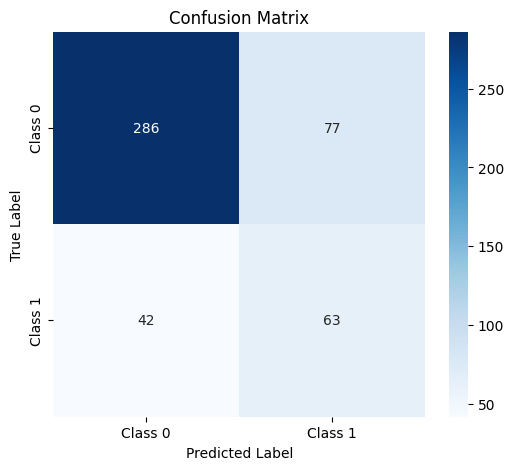

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       363
           1       0.45      0.60      0.51       105

    accuracy                           0.75       468
   macro avg       0.66      0.69      0.67       468
weighted avg       0.78      0.75      0.76       468



In [ ]:
test_loss, test_accuracy, test_precision, test_recall = fused_model.evaluate(
    [X_test_logmel_padded, X_test_mfcc_padded_fed], y_test
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate predictions from the model
y_pred_probs = fused_model.predict([X_test_logmel_padded, X_test_mfcc_padded_fed])
y_pred = (y_pred_probs > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

### attention instead of fusion

add attention layer after concatenation to learn features that are more important, it weights the features from each branch.

In [ ]:
combined_att = Concatenate()([feature_6, feature_3])

# Create an attention branch that outputs weights for the combined feature vector
# attention = Dense(224, activation='sigmoid')(combined)  # 224 = 64 + 160
# attended = Multiply()([combined, attention])

attention = Dense(combined.shape[-1], activation='sigmoid', name='attention_weights')(combined)
attended = Multiply(name='attended_features')([combined, attention])

# Additional layers after fusion
a = Dense(128, activation='relu')(attended)
a = Dropout(0.3)(a)
a = Dense(64, activation='relu')(a)
a = Dropout(0.3)(a)
output = Dense(1, activation='sigmoid')(a)  # Final binary classification

# Build the fused model
fused_model_att = Model(inputs=[input_6, input_3], outputs=output)

In [ ]:
# Compile the model
fused_model_att.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='binary_crossentropy',
                    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

fused_model_att.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ logmel_input (InputLayer) │ (None, 184, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 184, 64, 16)    │            160 │ logmel_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 184, 64, 16)    │             64 │ conv2d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mfcc_input (InputLayer)   │ (None, 184, 13, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 92, 32, 16)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 184, 13, 16)    │            160 │ mfcc_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 92, 32, 32)     │          4,640 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 184, 13, 16)    │             64 │ conv2d_33[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 92, 32, 32)     │            128 │ conv2d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 92, 6, 16)      │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_31          │ (None, 46, 16, 32)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 92, 6, 32)      │          4,640 │ max_pooling2d_33[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 46, 16, 64)     │         18,496 │ max_pooling2d_31[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 92, 6, 32)      │            128 │ conv2d_34[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 46, 16, 64)     │            256 │ conv2d_32[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34     

 Total params: 427,777 (1.63 MB)

 Trainable params: 427,329 (1.63 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
fused_att_history = fused_model_att.fit([X_train_split, X_train_fed], y_train_split,
                                batch_size=16,
                                epochs=50,
                                validation_data=([X_val_split, X_val_fed], y_val_split),
                                callbacks=[early_stopping, lr_scheduler],
                                class_weight=class_weights_dict)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.5324 - loss: 0.7252 - precision: 0.3414 - recall: 0.6734 - val_accuracy: 0.6132 - val_loss: 0.6783 - val_precision: 0.3713 - val_recall: 0.6048 - learning_rate: 1.0000e-04
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6535 - loss: 0.6861 - precision: 0.4261 - recall: 0.7545 - val_accuracy: 0.5956 - val_loss: 0.6679 - val_precision: 0.3696 - val_recall: 0.6855 - learning_rate: 1.0000e-04
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7119 - loss: 0.6453 - precision: 0.4784 - recall: 0.7594 - val_accuracy: 0.6549 - val_loss: 0.6449 - val_precision: 0.4035 - val_recall: 0.5565 - learning_rate: 1.0000e-04
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6693 - loss: 0.6455 - precision: 0.4447 - recall: 0.7619 - val_accuracy: 0.4945 - val_loss: 0.7618 - val_precision: 0.3245 - val_recall: 0.7903 - learning_rate: 1.0000e-04
Epoch 5/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7305 - loss: 0.6007 - precision: 0.4332 - recall: 0.7119
Test Loss: 0.6085
Test Accuracy: 0.7137
Test Precision: 0.4142
Test Recall: 0.6667
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


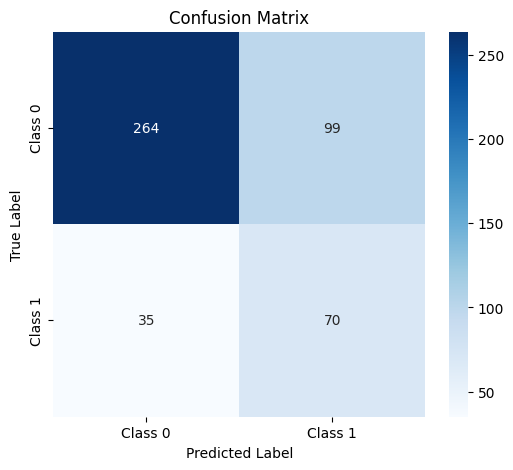

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       363
           1       0.41      0.67      0.51       105

    accuracy                           0.71       468
   macro avg       0.65      0.70      0.65       468
weighted avg       0.78      0.71      0.73       468



In [ ]:
test_loss, test_accuracy, test_precision, test_recall = fused_model_att.evaluate(
    [X_test_logmel_padded, X_test_mfcc_padded_fed], y_test
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate predictions from the model
y_pred_probs = fused_model_att.predict([X_test_logmel_padded, X_test_mfcc_padded_fed])
y_pred = (y_pred_probs > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))